In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [10]:
tryCount = train["Count"]
tryCount = tryCount.values
tryCount = tryCount.astype('float32')
tryCount

array([   8.,    2.,    6., ...,  702.,  580.,  534.], dtype=float32)

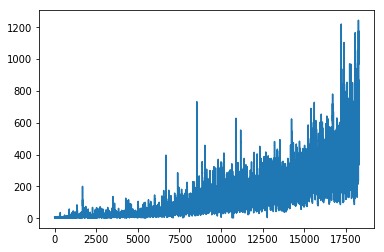

In [15]:
plt.plot(tryCount)
plt.show()

In [16]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [17]:
# fix random seed for reproducibility
np.random.seed(7)

In [20]:
# normalise the dataset
scaler = MinMaxScaler(feature_range=(0,1))
tryCount = tryCount.reshape(-1, 1)
tryCount = scaler.fit_transform(tryCount)
tryCount[:5]

array([[ 0.00483092],
       [ 0.        ],
       [ 0.00322061],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [22]:
# Split data into train and test set
train_size = int(len(tryCount) * 0.67)
test_size = len(tryCount) - train_size
train, test = tryCount[0:train_size,:], tryCount[train_size:len(tryCount),:]

In [24]:
len(train), len(test)

(12252, 6036)

In [25]:
def create_dataset(dataset, look_back=1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
print(create_dataset(tryCount)[1])

[ 0.          0.00322061  0.         ...,  0.5877617   0.5636071
  0.46537843]


In [28]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [29]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [30]:
trainX

array([[[ 0.00483092,  0.        ,  0.00322061]],

       [[ 0.        ,  0.00322061,  0.        ]],

       [[ 0.00322061,  0.        ,  0.        ]],

       ..., 
       [[ 0.04186796,  0.04669888,  0.04508857]],

       [[ 0.04669888,  0.04508857,  0.06441224]],

       [[ 0.04508857,  0.06441224,  0.07085346]]], dtype=float32)

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
30s - loss: 6.9019e-04
Epoch 2/500
28s - loss: 3.9784e-04
Epoch 3/500
29s - loss: 3.8511e-04
Epoch 4/500
29s - loss: 3.8109e-04
Epoch 5/500
28s - loss: 3.7983e-04
Epoch 6/500
28s - loss: 3.7668e-04
Epoch 7/500
29s - loss: 3.7671e-04
Epoch 8/500
28s - loss: 3.7644e-04
Epoch 9/500
29s - loss: 3.7505e-04
Epoch 10/500
28s - loss: 3.7533e-04
Epoch 11/500
28s - loss: 3.7219e-04
Epoch 12/500
28s - loss: 3.7160e-04
Epoch 13/500
28s - loss: 3.7274e-04
Epoch 14/500
28s - loss: 3.7280e-04
Epoch 15/500
28s - loss: 3.7268e-04
Epoch 16/500
28s - loss: 3.7073e-04
Epoch 17/500
29s - loss: 3.7071e-04
Epoch 18/500
28s - loss: 3.6986e-04
Epoch 19/500
29s - loss: 3.7054e-04
Epoch 20/500
28s - loss: 3.7011e-04
Epoch 21/500
28s - loss: 3.6987e-04
Epoch 22/500
28s - loss: 3.6925e-04
Epoch 23/500
28s - loss: 3.6920e-04
Epoch 24/500
28s - loss: 3.6985e-04
Epoch 25/500
27s - loss: 3.6766e-04
Epoch 26/500
26s - loss: 3.6634e-04
Epoch 27/500
26s - loss: 3.7019e-04
Epoch 28/500
27s - loss: 3.6872e-04
E

KeyboardInterrupt: 

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(tryCount)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(tryCount)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(tryCount)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(tryCount))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'trainPredict' is not defined